In [1]:
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import re
# Scenario folder
folder = '../logs/commons_harvest_open/scenario_0_5players'
indicators_filename = 'custom_indicators.json'
rewards_history_filename = 'rewards_history.txt'

# Colors for the generative agents architecture and the CoT architecture
SUBCAT_COLORS = [{'facecolor': 'lightblue', 'color': 'blue'},
    {'facecolor': 'lightgreen', 'color': 'green'}
]

In [2]:
def get_results_by_category_and_subcategory(indicators, llm_model, indicator_name, categories, agg_fn):
    """
    Returns a dictionary with the categories as keys and as values a dictionary with the subcategories as keys and a list 
    with the values for each simulation

    Parameters:
    indicators (dict): The indicators dictionary
    llm_model (str): The LLM model
    indicator_name (str): The name of the indicator
    categories (list): The name of the categories
    agg_fn (function): The function to aggregate the values for the agents
    """
    subcategories = list(indicators.keys())

    if indicator_name:
        subcategories_results = {subcat: get_indicator_by_simulation(indicators[subcat][llm_model], indicator_name) for subcat in subcategories}
    else:
        subcategories_results = {subcat: indicators[subcat][llm_model] for subcat in subcategories}
    
    # If there are no categories, return the results by subcategory
    if not categories:
        results = {}
        for subcat in subcategories:
            results[subcat] = agg_fn(subcategories_results[subcat], None)
        return results

    results_by_cat = {}
    for cat in categories:
        results_by_cat[cat] = {}
        for subcat in subcategories:
            results_by_cat[cat][subcat] = agg_fn(subcategories_results[subcat], cat)
    return results_by_cat

In [98]:
def create_box_plot(results, subcat_colors, norm_across_cats=False, **kwargs):
    """
    Creates a box plot with the results of the indicators
    The results are a dictionary with (categories) as keys and as values a dictionary with subcategories as keys and a list with the values for each simulation

    Parameters:
    results (dict): The results of the indicators
    subcat_colors (list): A list with the colors for each subcategory. Each element is a dictionary with the facecolor and the color
    norm_across_cats (bool): If True, the values will be normalized across categories
    **kwargs: Additional parameters for the plot. title and ylabel are supported
    """
    categories = list(results.keys())
    try:
        subcategories = list(results[categories[0]].keys())

    except:
        # If there are is an exception is because the data has no categories
        subcategories = categories
        categories = None
        

    if norm_across_cats and categories is not None:
        results = np.array(list(map(lambda x: list(x.values()), results.values()))) # 3 dimensions: categories, subcategories, simulations
        # Mask to avoid division by zero
        mask = results.sum(axis=0, keepdims=True) == 0
        results = results/(results.sum(axis=0, keepdims=True)+mask)

    if categories is None:
        positions = np.arange(len(subcategories))+1
    else:
        positions = np.arange(len(categories)*len(subcategories))+1
    if kwargs['scale_xticks']:
        positions = positions*kwargs['scale_xticks']
    if kwargs['xticks_translation']:
        positions += kwargs['xticks_translation']

    fig, ax = plt.subplots(**kwargs.get('subplots_kwargs',{}))
    for s, subcategory in enumerate(subcategories):
        boxprops = subcat_colors[s].copy()
        if categories is not None:
            if norm_across_cats:
                data = [results[c][s] for c in range(len(categories))]
            else:
                data = [results[c][subcategory] for c in categories]
        else:
            # data = results[s]
            data = results[subcategory]
        
        ax.boxplot(data, positions=positions[s::len(subcategories)], patch_artist=True, boxprops=boxprops, showmeans=True)

    if categories is not None:
        plt.xticks(positions[::len(subcategories)], kwargs['xticks_names'] if kwargs['xticks_names'] else categories)
    else:
        plt.xticks(positions, kwargs['xticks_names'] if kwargs['xticks_names'] else subcategories)

    if 'title' in kwargs:
        plt.title(kwargs['title'])
    if 'ylabel' in kwargs:
        plt.ylabel(kwargs['ylabel'])

    if categories is not None:
        legend_elements = [Patch(facecolor=subcat_colors[i]['facecolor'], edgecolor=subcat_colors[i]['color'], \
                                label=subcategory) for i, subcategory in enumerate(subcategories)]
        plt.legend(handles=legend_elements, loc='upper right')

    return ax


def create_line_plot(results, subcat_colors, agg=np.mean, norm_across_cats=False, **kwargs):
    """
    Creates a box plot with the results of the indicators
    The results are a dictionary with (categories) as keys and as values a dictionary with subcategories as keys and a list with the values for each simulation

    Parameters:
    results (dict): The results of the indicators
    subcat_colors (list): A list with the colors for each subcategory. Each element is a dictionary with the facecolor and the color
    agg (function): The function to aggregate the results. There should be a single value per category-subcategory
    norm_across_cats (bool): If True, the values will be normalized across categories
    **kwargs: Additional parameters for the plot. title and ylabel are supported
    """
    categories = list(results.keys())
    subcategories = list(results[categories[0]].keys())
    # results = np.array(list(map(lambda x: list(x.values()), results.values()))) # 3 dimensions: categories, subcategories, simulations

    # if norm_across_cats and categories is not None:
    #     # Mask to avoid division by zero
    #     mask = results.sum(axis=0, keepdims=True) == 0
    #     results = results/(results.sum(axis=0, keepdims=True)+mask)

    positions = np.arange(len(categories))

    for s, subcategory in enumerate(subcategories):
        data = [agg(results[c][subcategory]) for c in categories]
        plt.plot(data, label=subcategory, color=subcat_colors[s]['color'])

    plt.xticks(positions, categories)

    if 'title' in kwargs:
        plt.title(kwargs['title'])
    if 'ylabel' in kwargs:
        plt.ylabel(kwargs['ylabel'])
    if 'xlabel' in kwargs:
        plt.xlabel(kwargs['xlabel'])

    legend_elements = [Patch(facecolor=subcat_colors[i]['facecolor'], edgecolor=subcat_colors[i]['color'], \
                            label=subcategory) for i, subcategory in enumerate(subcategories)]
    plt.legend(handles=legend_elements, loc='upper right')

    plt.show()

In [4]:
def agents_mean(actions_indicator_by_sim, category):
    if category is None:
        result = [[sim[agent] for agent in sim if 'bot' not in agent] for sim in actions_indicator_by_sim]
    else:
        result = [[sim[agent][category] if category in sim[agent] else 0 for agent in sim if 'bot' not in agent] for sim in actions_indicator_by_sim]
    return [sum(cat_result)/len(cat_result) if len(cat_result) > 0 else 0 for cat_result in result]

In [5]:
def bots_mean(actions_indicator_by_sim, category):
    if category is None:
        result = [[sim[agent] for agent in sim if 'bot' in agent] for sim in actions_indicator_by_sim]
    else:
        result = [[sim[agent][category] if category in sim[agent] else 0 for agent in sim if 'bot' in agent] for sim in actions_indicator_by_sim]
    return [sum(cat_result)/len(cat_result) if len(cat_result) > 0 else 0 for cat_result in result]

# Reward analysis

In [6]:
def get_metrics_of_simulation(filename):
    rewards = {}
    exec_time = 0
    total_cost = 0
    with open(filename, 'r') as f:
        reward_patt = r'.*end_game:\d+ - Player (\w+): score is (\d+(\.\d+)?)'
        time_patt = r'.* - Execution time: (\d+(\.\d+)?)'
        cost_patt = r'.*- LLM total cost: (\d+(\.\d+)?)'
        for line in f:
            m_reward = re.search(reward_patt, line)
            m_time = re.search(time_patt, line)
            m_cost = re.search(cost_patt, line)
            if m_reward:
                rewards[m_reward.group(1)] = float(m_reward.group(2))
            elif m_cost:
                total_cost = float(m_cost.group(1))
            elif m_time:
                exec_time = float(m_time.group(1))
    return rewards, exec_time, total_cost

In [7]:
rewards = {}
costs = {}
exec_times = {}
# Get the list of agents architectures
LAAs_models = os.listdir(folder)
# Iterate over the agents architectures
for model in LAAs_models:
    model_path = os.path.join(folder, model)
    # Get the list of LLMs
    llm_models = os.listdir(model_path)

    rewards[model] = {}
    costs[model] = {}
    exec_times[model] = {}

    # Iterate over the LLMs per agent architecture
    for llm_model in llm_models:
        # Get the list of simulations per LLM and agent architecture
        llm_model_path = os.path.join(model_path, llm_model)

        rewards[model][llm_model] = []
        costs[model][llm_model] = []
        exec_times[model][llm_model] = []

        # Iterate over the simulations
        for sim_folder in os.listdir(llm_model_path):
            # skip if it is not a folder
            if not os.path.isdir(os.path.join(llm_model_path, sim_folder)):
                continue

            patt = r'\d{4}-\d{2}-\d{2}--\d{2}-\d{2}-\d{2}'
            folder_time = re.search(patt, sim_folder)
            rewards_filename = folder_time.group() + '.log'

            # Load the rewards of the simulation
            rewards_file = os.path.join(llm_model_path, sim_folder, rewards_filename)
            sim_rewards, sim_time, sim_cost = get_metrics_of_simulation(rewards_file)
            rewards[model][llm_model].append(sim_rewards)
            costs[model][llm_model].append(sim_cost)
            exec_times[model][llm_model].append(sim_time)

Total costs

In [8]:
costs_results = {}
for arch in costs:
    costs_results[arch] = {}
    for llm in costs[arch]:
        costs_results[arch][llm] = {'mean': np.mean(costs[arch][llm]), 'std': np.std(costs[arch][llm])}

# Make a table with the costs
df = pd.DataFrame(costs_results)
df

,GA+comm,GenAgents,CoTAgents
gpt4o_mini,"{'mean': 0.45299999999999996, 'std': 0.0914385...","{'mean': 0.22900000000000004, 'std': 0.0372692...","{'mean': 0.016, 'std': 0.008}"
llama31_8b,NaN,"{'mean': 0.183, 'std': 0.026851443164195098}",NaN
llama31_70b,NaN,"{'mean': 0.772, 'std': 0.08304215796810678}",NaN


Total execution time

In [9]:
time_results = {}
for arch in exec_times:
    time_results[arch] = {}
    for llm in exec_times[arch]:
        time_results[arch][llm] = {'mean': np.mean(exec_times[arch][llm]), 'std': np.std(exec_times[arch][llm])}

# Make a table with the costs
df = pd.DataFrame(time_results)
df

,GA+comm,GenAgents,CoTAgents
gpt4o_mini,"{'mean': 77.84400000000001, 'std': 17.16189803...","{'mean': 62.197, 'std': 14.205365922777208}","{'mean': 5.647, 'std': 1.8733715595150902}"
llama31_8b,NaN,"{'mean': 32.019000000000005, 'std': 5.48593009...",NaN
llama31_70b,NaN,"{'mean': 44.584999999999994, 'std': 7.01146953...",NaN


Total rewards

In [10]:
rewards

{'GA+comm': {'gpt4o_mini': [{'Angie': 12.0,
    'David': 9.0,
    'Juan': 7.0,
    'Laura': 11.0,
    'Pedro': 7.0,
    'bot_1': 16.0,
    'bot_2': 12.0},
   {'Angie': 4.0,
    'David': 12.0,
    'Juan': 13.0,
    'Laura': 2.0,
    'Pedro': 1.0,
    'bot_1': 22.0,
    'bot_2': 19.0},
   {'Angie': 12.0,
    'David': 6.0,
    'Juan': 9.0,
    'Laura': 6.0,
    'Pedro': 3.0,
    'bot_1': 20.0,
    'bot_2': 16.0},
   {'Angie': 10.0,
    'David': 13.0,
    'Juan': 5.0,
    'Laura': 14.0,
    'Pedro': 15.0,
    'bot_1': 0.0,
    'bot_2': 13.0},
   {'Angie': 14.0,
    'David': 9.0,
    'Juan': 7.0,
    'Laura': 9.0,
    'Pedro': 14.0,
    'bot_1': 3.0,
    'bot_2': 13.0},
   {'Angie': 10.0,
    'David': 5.0,
    'Juan': 7.0,
    'Laura': 8.0,
    'Pedro': 5.0,
    'bot_1': 7.0,
    'bot_2': 23.0},
   {'Angie': 11.0,
    'David': 11.0,
    'Juan': 10.0,
    'Laura': 13.0,
    'Pedro': 5.0,
    'bot_1': 15.0,
    'bot_2': 12.0},
   {'Angie': 10.0,
    'David': 21.0,
    'Juan': 15.0,
    'Laura

In [11]:
rewards_results = {}
for arch in rewards:
    rewards_results[arch] = {}
    for llm in rewards[arch]:
        data = list(map(lambda x: (x['Juan'] + x['Laura'] + x['Pedro'] + x['David'] + x['Angie'])/5, rewards[arch][llm]))
        rewards_results[arch][llm] = {'mean': np.mean(data), 'std': np.std(data)}

# Make a table with the costs
df = pd.DataFrame(rewards_results)
df

,GA+comm,GenAgents,CoTAgents
gpt4o_mini,"{'mean': 9.200000000000001, 'std': 1.654085850...","{'mean': 8.6, 'std': 0.9380831519646861}","{'mean': 6.1, 'std': 1.6786899654194638}"
llama31_8b,NaN,"{'mean': 7.18, 'std': 1.4211263138792416}",NaN
llama31_70b,NaN,"{'mean': 8.879999999999999, 'std': 1.074057726...",NaN


In [56]:
llms = ['gpt4o_mini', 'llama31_70b', 'llama31_8b']
rewards_results = {}
for llm in llms:
    rewards_results[llm] = []
    r = agents_mean(rewards['GenAgents'][llm], None)
    rewards_results[llm].append(r)
rewards_results

{'gpt4o_mini': [[7.8, 9.4, 7.8, 8.2, 8.4, 9.2, 7.4, 10.8, 8.6, 8.4]],
 'llama31_70b': [[8.6, 8.0, 9.2, 9.8, 11.0, 7.0, 9.8, 8.8, 8.6, 8.0]],
 'llama31_8b': [[5.6, 6.6, 5.6, 8.4, 8.6, 9.8, 6.2, 5.8, 6.8, 8.4]]}

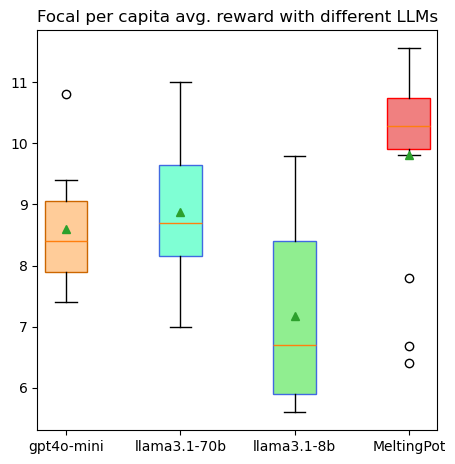

In [100]:
# rewards_results = get_results_by_category_and_subcategory(rewards, 'gpt4o_mini', None, None, agents_mean)
rewards_results['Meltingpot'] = [
    10.28994709,
    10.1135376,
    10.39208633,
    10.76997539,
    10.7430223,
    11.55376261,
    10.67341772,
    10.00926984,
    9.814327657,
    10.11118922,
    6.675783972,
    6.410152838,
    7.794463668,
    10.746139,
    11.05280289
]
subcat_colors = [
    {"facecolor": "#ffcc99", "color": "#cc6600"},  # GPT4o-mini (CoTAgents y GenAgents)
    # {"facecolor": "#66b3ff", "color": "#003366"},   # GPT4o (CoTAgents y GenAgents)
    {'facecolor': 'aquamarine', 'color': 'royalblue'}, # Llama 70b
    {'facecolor': 'lightgreen', 'color': 'royalblue'}, # Llama 8b
    {'facecolor': 'lightcoral', 'color': 'red'}, # MeltingPot
]
title = 'Focal per capita avg. reward with different LLMs'
ax = create_box_plot(rewards_results, subcat_colors, title=title, scale_xticks=0.4, 
                     xticks_translation=-0.3, subplots_kwargs={'figsize':(5,5)},
                     xticks_names=['gpt4o-mini', 'llama3.1-70b', 'llama3.1-8b', 'MeltingPot']
                     )
# ax.margins(0)
ax.set_xlim(0, 1.4)
plt.subplots_adjust(left=0, right=0.8, top=0.9, bottom=0.1)
plt.show()

In [101]:
rewards_results

{'gpt4o_mini': [[7.8, 9.4, 7.8, 8.2, 8.4, 9.2, 7.4, 10.8, 8.6, 8.4]],
 'llama31_70b': [[8.6, 8.0, 9.2, 9.8, 11.0, 7.0, 9.8, 8.8, 8.6, 8.0]],
 'llama31_8b': [[5.6, 6.6, 5.6, 8.4, 8.6, 9.8, 6.2, 5.8, 6.8, 8.4]],
 'Meltingpot': [10.28994709,
  10.1135376,
  10.39208633,
  10.76997539,
  10.7430223,
  11.55376261,
  10.67341772,
  10.00926984,
  9.814327657,
  10.11118922,
  6.675783972,
  6.410152838,
  7.794463668,
  10.746139,
  11.05280289]}